<a href="https://colab.research.google.com/github/ThierrryScotto/Optuna-XGBoost-hyperparameter/blob/main/Optuna_XGBoost_hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import sklearn

sns.set()
%config InlineBeckend.figure_formar = 'retina'
warnings.filterwarnings("ignore")

## Loading the boston dataset

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

In [3]:
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['target']  = boston.target

In [4]:
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [5]:
X = df.iloc[:, df.columns != 'target']
y = df.target

### Scaling data

In [6]:
from sklearn.preprocessing import StandardScaler
se = StandardScaler()
X = se.fit_transform(X)

### Split data into training and test

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

**Converting the training and test data into xgboost optimized matrix for efficiency**

In [8]:
df_train = xgb.DMatrix(X_train, y_train)
df_test = xgb.DMatrix(X_test, y_test)

### Testing a base model

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, ShuffleSplit

cv_ = KFold(n_splits=10)
xg_reg = xgb.XGBRFRegressor()
scores = cross_val_score(xg_reg, X_train, y_train, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv_)

In [10]:
print(np.mean(scores), np.std(scores))
print(scores)

-4.690851864521107 0.9137364320425729
[-4.46876379 -4.44228761 -4.73628169 -5.57790661 -3.89063134 -5.08357565
 -5.49483956 -3.32361937 -6.36116408 -3.52944895]


#### Creating a scoring funtion with the help of XGBOOST train inbuilt early stopping
here we are not tuning the n_estimators with the help of optuna

we will tune the n_estimators with the help of early_stopping by using the xgboost.train

In [11]:
import re
def return_rmse(params):
  model = xgb.train(params, df_train, num_boost_round=600, evals=[(df_test, 'eval')], early_stopping_rounds=20, verbose_eval=0)
  result = model.eval(df_test)
  result = np.float(re.search(r'[\d.]+$', result).group(0))
  # print(result)
  return result

#### importing optuna

In [12]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 2.1 MB/s eta 0:00:00


In [13]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

In [14]:
def objective(trial):
    param = {
                # "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth', 3, 10),
                'reg_alpha':trial.suggest_uniform('reg_alpha', 0, 6),
                'reg_lambda':trial.suggest_uniform('reg_lambda', 0, 2),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 5),
                'gamma':trial.suggest_uniform('gamma', 0, 4),
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.05, 0.5),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.4, 0.9),
                'subsample':trial.suggest_uniform('subsample', 0.4, 0.9),
                'nthread' : -1
            }
    return(return_rmse(param)) # this will return the rmse score 

**calling the optuna study**

In [15]:
study1 = optuna.create_study(direction='minimize', sampler=TPESampler())
# study1.optimize(objective, n_trials=1050, show_progress_bar=True)
study1.optimize(objective, n_trials=700, show_progress_bar=True)

[I 2023-01-20 14:32:18,186] A new study created in memory with name: no-name-93b01134-92a2-4d29-b74f-5f820d278545


  0%|          | 0/700 [00:00<?, ?it/s]

[I 2023-01-20 14:32:18,753] Trial 0 finished with value: 3.268122 and parameters: {'max_depth': 5, 'reg_alpha': 2.8859633410797647, 'reg_lambda': 1.3215286287058619, 'min_child_weight': 5, 'gamma': 0.10513482991686685, 'learning_rate': 0.05546736385068028, 'colsample_bytree': 0.7237664801130848, 'subsample': 0.6340845410893855}. Best is trial 0 with value: 3.268122.
[I 2023-01-20 14:32:18,844] Trial 1 finished with value: 3.680583 and parameters: {'max_depth': 5, 'reg_alpha': 3.858128990798665, 'reg_lambda': 0.5818721945902414, 'min_child_weight': 5, 'gamma': 0.35266078711454396, 'learning_rate': 0.4959856235164936, 'colsample_bytree': 0.868393838757735, 'subsample': 0.4318060579275494}. Best is trial 0 with value: 3.268122.
[I 2023-01-20 14:32:19,326] Trial 2 finished with value: 3.231487 and parameters: {'max_depth': 6, 'reg_alpha': 0.5524667530872742, 'reg_lambda': 1.3775506525842716, 'min_child_weight': 1, 'gamma': 2.8459493541233463, 'learning_rate': 0.06493663664679167, 'colsampl

#### **Printing the best estimators**

In [16]:
return_rmse(study1.best_params)

2.842838

In [17]:
trial = study1.best_trial
print('rmse: {}'.format(trial.value))

rmse: 2.842838


In [18]:
study1.best_params

{'max_depth': 10,
 'reg_alpha': 0.45020292999397615,
 'reg_lambda': 0.8190260120427361,
 'min_child_weight': 0,
 'gamma': 2.308945344926442,
 'learning_rate': 0.13839399999275312,
 'colsample_bytree': 0.8566526791870985,
 'subsample': 0.7312678122744489}

## Without using any hypeparameter tuning

In [19]:
params = {}
print(f"Without tuning {return_rmse(params)}\n")
print(f"With tuning {return_rmse(study1.best_params)}")

Without tuning 3.214825

With tuning 2.842838


### Plotting of our search history

In [20]:
optuna.visualization.plot_optimization_history(study1)

In [21]:
optuna.visualization.plot_slice(study1)

## Tuning again with more narrower values to get the sweet spot

In [36]:
def objective(trial):
   
    param = {
                # "n_estimators" : trial.suggest_int('n_estimators', 0, 500),
                'max_depth':trial.suggest_int('max_depth', 5, 10),
                'reg_alpha':trial.suggest_uniform('reg_alpha', 0, 2),
                'reg_lambda':trial.suggest_uniform('reg_lambda', 0.5, 1),
                'min_child_weight':trial.suggest_int('min_child_weight', 0, 0),
                'gamma':trial.suggest_int('gamma', 2, 3),
                'learning_rate':trial.suggest_loguniform('learning_rate',0.09, 0.2),
                'colsample_bytree':trial.suggest_uniform('colsample_bytree',0.8, 0.9),
                'subsample':trial.suggest_uniform('subsample', 0.6, 0.8),
                'nthread' : -1
             }
    return(return_rmse(param))

**Calling the optuna study**

In [37]:
study2 = optuna.create_study(direction='minimize', sampler=TPESampler())
# study2.optimize(objective, n_trials=1050, show_progress_bar=True)
study2.optimize(objective, n_trials=300, show_progress_bar=True)

[I 2023-01-20 14:58:23,791] A new study created in memory with name: no-name-f9991e53-4d77-44ac-8a8d-d908cfdef21d


  0%|          | 0/300 [00:00<?, ?it/s]

[I 2023-01-20 14:58:24,040] Trial 0 finished with value: 3.154705 and parameters: {'max_depth': 7, 'reg_alpha': 0.38220203151202004, 'reg_lambda': 0.9347985244708901, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.0934238698729527, 'colsample_bytree': 0.8131475580091646, 'subsample': 0.7906369807095663}. Best is trial 0 with value: 3.154705.
[I 2023-01-20 14:58:24,183] Trial 1 finished with value: 3.107979 and parameters: {'max_depth': 8, 'reg_alpha': 0.4261108573718113, 'reg_lambda': 0.6411529232204152, 'min_child_weight': 0, 'gamma': 2, 'learning_rate': 0.16048591763205874, 'colsample_bytree': 0.8149748596423991, 'subsample': 0.7529413608181411}. Best is trial 1 with value: 3.107979.
[I 2023-01-20 14:58:24,445] Trial 2 finished with value: 3.100024 and parameters: {'max_depth': 5, 'reg_alpha': 0.9063891523738181, 'reg_lambda': 0.6746423145286979, 'min_child_weight': 0, 'gamma': 3, 'learning_rate': 0.09479320722097466, 'colsample_bytree': 0.8229789971044184, 'subsample': 0.6449

In [38]:
optuna.visualization.plot_optimization_history(study2)

In [39]:
study2.best_params

{'max_depth': 10,
 'reg_alpha': 0.5501744534668473,
 'reg_lambda': 0.6790821987967159,
 'min_child_weight': 0,
 'gamma': 2,
 'learning_rate': 0.13738304426338965,
 'colsample_bytree': 0.8330559930494197,
 'subsample': 0.7735816943606633}

In [40]:
params = {}
print(f"withou tuning: {return_rmse(params)}\n")
print(f"With tuning params 1: {return_rmse(study1.best_params)}\n")
print(f"With tuning params 2: {return_rmse(study2.best_params)}")

withou tuning: 3.214825

With tuning params 1: 2.842838

With tuning params 2: 2.775993


## Visualising the overfitting and underfitting and finding the best estimators

In [41]:
from sklearn.model_selection import validation_curve

param_range = np.arange(10, 250, 2)

train_scores = []
test_scores = []

for i in param_range:
  xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', **study2.best_params, n_estimators=i)
  xg_reg.fit(X_train, y_train)

  train_scores.append(np.sqrt(mean_squared_error(y_train, xg_reg.predict(X_train))))
  test_scores.append(np.sqrt(mean_squared_error(y_test ,xg_reg.predict(X_test))))

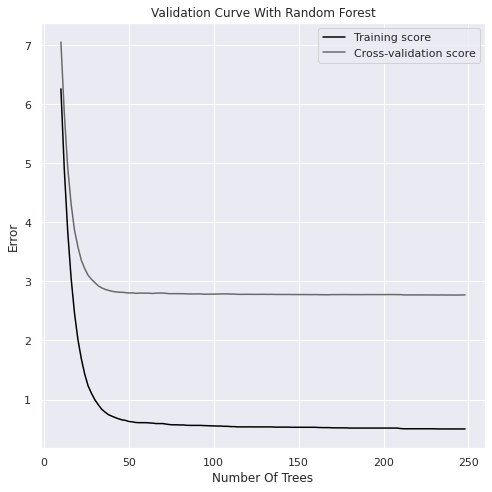

In [42]:
plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_scores, label="Training score", color="black")
plt.plot(param_range, test_scores, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Error")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

#### Finding the best n_estimators with the early stopping

In [43]:
model = xgb.train(study2.best_params, df_train, num_boost_round=600, evals=[(df_test, 'eval')],
                  early_stopping_rounds=20, verbose_eval=1)

[0]	eval-rmse:21.2344
Will train until eval-rmse hasn't improved in 20 rounds.
[1]	eval-rmse:18.4885
[2]	eval-rmse:16.2414
[3]	eval-rmse:14.2547
[4]	eval-rmse:12.6017
[5]	eval-rmse:11.1155
[6]	eval-rmse:9.80923
[7]	eval-rmse:8.77505
[8]	eval-rmse:7.87348
[9]	eval-rmse:7.05219
[10]	eval-rmse:6.39219
[11]	eval-rmse:5.84441
[12]	eval-rmse:5.35491
[13]	eval-rmse:4.92713
[14]	eval-rmse:4.57578
[15]	eval-rmse:4.31414
[16]	eval-rmse:4.07202
[17]	eval-rmse:3.86733
[18]	eval-rmse:3.72003
[19]	eval-rmse:3.58738
[20]	eval-rmse:3.46037
[21]	eval-rmse:3.3597
[22]	eval-rmse:3.29372
[23]	eval-rmse:3.21717
[24]	eval-rmse:3.15599
[25]	eval-rmse:3.10481
[26]	eval-rmse:3.07283
[27]	eval-rmse:3.03489
[28]	eval-rmse:2.99628
[29]	eval-rmse:2.98002
[30]	eval-rmse:2.95263
[31]	eval-rmse:2.92422
[32]	eval-rmse:2.9159
[33]	eval-rmse:2.89101
[34]	eval-rmse:2.86918
[35]	eval-rmse:2.86585
[36]	eval-rmse:2.85708
[37]	eval-rmse:2.84901
[38]	eval-rmse:2.84024
[39]	eval-rmse:2.83243
[40]	eval-rmse:2.82495
[41]	eval-rm

## Final Model

In [44]:
xgb_regressor = xgb.XGBRegressor(objective ='reg:squarederror', **study2.best_params, n_estimators= 71)
xgb_regressor_base = xgb.XGBRegressor(objective ='reg:squarederror')

In [45]:
xgb_regressor_base.fit(X_train, y_train)
score1 = xgb_regressor_base.score(X_test, y_test)

xgb_regressor.fit(X_train, y_train)
score2 = xgb_regressor.score(X_test, y_test)

print(f"R2 score withouth tuning: {score1}\nR2 score with tuning: {score2}")

R2 score withouth tuning: 0.8646010514688809
R2 score with tuning: 0.9040765456406504
